In [1]:
#First we will define some functions

def OLS(y, X, robust):
    T = X.shape[0]
    K = X.shape[1]+1
    X = sm.add_constant(X)
    XY=np.dot(np.transpose(X),y)
    b=np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),XY)
    res=y-np.dot(X,b)
    if robust=="none":
        sig2 = 1/(T-K)* np.dot(np.transpose(res),res)
        var_b=np.diag(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.diag(np.full(K, sig2))))   
    if robust=="White":
        invXpX = np.linalg.inv(np.dot(np.transpose(X),X)) 
        XpEuupX = np.zeros((4,4), dtype=float);
        for i in range(0,T):
            x = np.transpose(X[i,:])
            r2 = np.power(res[i],2)
            XpEuupX = XpEuupX + (T*r2)/(T-K)* (np.outer(x,np.transpose(x)))
        var_b = np.diag(np.dot(np.dot(invXpX,XpEuupX),invXpX))                     
    if robust=="NW":
        invXpX = np.linalg.inv(np.dot(np.transpose(X),X)) 
        XpEuupX_1 = np.zeros((4,4), dtype=float);
        for i in range(0,T):
            x = np.transpose(X[i,:])
            r2 = np.power(res[i],2)
            XpEuupX_1 = XpEuupX_1 + (T)/(T-K)* r2 * (np.outer(x,np.transpose(x)))
        XpEuupX_2_tot = np.zeros((4,4), dtype=float);
        M = 12
        for j in range(0,M):
            kern = 1 - (j+1)/(M-1)
            XpEuupX_2_part = np.zeros((4,4), dtype=float);
            start=j+1
            for i in range(start,T):
                xt = np.transpose(X[i,:])
                xt_j = np.transpose(X[i-j-1,:])
                utut_j = res[i]*res[i-j-1]
                xtpxt_j = np.outer(np.transpose(xt),xt_j)
                xt_jpxt = np.outer(np.transpose(xt_j),xt)
                XpEuupX_2_part = XpEuupX_2_part + utut_j * (xtpxt_j + xt_jpxt)
            XpEuupX_2_tot = XpEuupX_2_tot + (T)/(T-K) * kern * XpEuupX_2_part
        XpEuupX = XpEuupX_1 +XpEuupX_2_tot
        var_b = np.diag(np.dot(np.dot(invXpX,XpEuupX),invXpX))        
    std_b = np.sqrt(var_b)
    tstat = b/std_b
    pval = 2 * (1-norm.cdf(abs(tstat)))
  
    R2 = 1 - (np.dot(np.transpose(res),res))/(np.dot(np.transpose(y-np.mean(y)),y-np.mean(y)))
    print("R2",R2)
  
    rho_1 = 1/T*np.sum(res[1:T]*res[0:T-1])
    print("rho_1(u)",rho_1)
  
    DW=np.sum(np.power(res[1:T]-res[0:T-1],2))/np.sum(res*res)
    print("DW",DW)
  
    z_DW=np.sqrt(T)*(DW/2 - 1)
    print("z_DW",z_DW)
  
    pval_z = 2 * (1-norm.cdf(abs(z_DW)))
    print("pval z_DW",pval_z)
  
    value =np.vstack((b,std_b,tstat,pval))
    value=np.transpose(value)
    return(value)

In [2]:
from datetime import datetime
import pandas as pd 
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm


todayM  = datetime.now().month
todayY = datetime.now().year
print(todayM )
print(todayY)

3
2019


In [3]:
factors =pd.read_csv("F-F_Research_Data_Factors.CSV",sep=',',header =2,nrows=6+(todayY-1927)*12+todayM-2)
lenfact=factors.shape[0]
factors=factors[0:lenfact-1]
factors=factors.rename(columns={'Unnamed: 0':'X'})
factors['X']=factors['X'].astype(int)
factors.head()

#print(factors)
#print(factors.shape)

,X,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [4]:
portfolios=pd.read_csv("25_Portfolios_5x5.CSV",sep=',',header =9,nrows=6+(todayY-1927)*12+todayM-2)
lenport=portfolios.shape[0]
portfolios=portfolios[0:lenport-1]
portfolios=portfolios.rename(columns={'Unnamed: 0':'X'})
portfolios['X']=portfolios['X'].astype(int)
portfolios.head()
#print(portfolios)



,X,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
0,192607,3.7782,-0.4119,-1.9434,0.3530,2.0534,2.1904,2.4192,0.4926,-1.5770,...,1.5893,1.5278,1.1869,0.2727,2.4678,3.4539,6.0902,2.0266,3.1111,0.5623
1,192608,-2.2074,-8.7275,2.4404,0.6086,8.3968,2.1709,-1.1849,4.0084,0.4643,...,1.3336,3.8730,2.0059,2.1706,5.3422,1.0124,4.1903,2.0131,5.4849,7.7576
2,192609,-6.2113,-0.2989,-6.1982,-1.6368,0.8649,-1.8550,-1.2618,1.0829,-3.0405,...,1.0923,-0.5250,-1.7314,1.4646,0.8730,-1.2906,3.6538,0.0950,-0.7487,-2.4284
3,192610,-8.6241,-3.7532,-5.6719,5.7170,-2.5476,-1.7995,-3.2663,-5.0745,-8.0450,...,-3.3361,-2.6559,-2.0316,-3.1051,-5.3525,-2.7413,-3.0071,-2.2437,-4.6719,-5.8129
4,192611,3.4744,6.6476,2.2634,-4.7020,0.5362,2.9051,-2.3690,3.0078,4.6649,...,3.4448,2.3887,3.7403,4.9320,1.8213,4.2946,2.5326,1.5204,3.6619,2.5636


In [5]:
portfoliosA=portfolios[portfolios['X']>=196307]

portfoliosA.head()



,X,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
444,196307,1.1234,-0.1481,0.5563,0.1097,-1.3212,-1.8721,0.2945,-0.8445,-1.9644,...,-0.8456,-1.7052,-2.0042,-1.6657,-1.8567,0.1401,0.4524,1.2557,-0.4290,-1.1026
445,196308,4.2429,1.4831,1.3214,2.3701,4.6745,5.3983,4.6462,4.3639,4.4188,...,5.3965,4.7614,6.2068,7.5619,5.3469,5.7710,4.2230,4.7487,8.1419,6.3824
446,196309,-2.8922,0.7027,-1.0869,-1.5812,-0.3581,-3.9164,-1.5713,-0.6417,-1.1812,...,-2.6893,-2.0139,-1.8941,-3.5823,-1.9943,-1.3721,-0.7720,-0.9852,-0.1905,-3.4963
447,196310,1.2861,-0.6491,1.2443,0.1000,2.3724,1.1882,4.3011,2.3438,2.2012,...,-0.4287,0.9057,2.3459,5.3382,0.6113,5.3261,1.7383,-0.2829,2.4150,0.4857
448,196311,-3.3793,-4.0355,-1.5969,-1.0548,-1.0454,-4.1822,-1.7644,-0.7064,-0.1002,...,-0.8648,-0.8828,-0.4882,1.1451,3.5388,-1.2561,0.9849,-1.5542,-2.1322,1.3455


In [6]:
factorsA=factors[factors['X']>=196307]
factorsA.head()

,X,Mkt-RF,SMB,HML,RF
444,196307,-0.39,-0.56,-0.83,0.27
445,196308,5.07,-0.94,1.67,0.25
446,196309,-1.57,-0.31,0.18,0.27
447,196310,2.53,-0.54,-0.10,0.29
448,196311,-0.85,-1.13,1.71,0.27


In [7]:
factorsARF= factorsA['RF']
Ri_Rf1=np.zeros((portfoliosA.shape[0],portfoliosA.shape[1]-1), dtype=float); 
for i in range(1,portfoliosA.shape[1]):
    Ri_Rf1[:,i-1]=portfoliosA.iloc[:,i]-factorsARF

#print(Ri_Rf1)

In [8]:
means=np.zeros(25, dtype=float);
sd=np.zeros(25, dtype=float);
for i in range(0,25):
     means[i] = np.mean(Ri_Rf1[:,i])
     sd[i] = np.sqrt(np.var(Ri_Rf1[:,i]))
    
panel_A_means =means.reshape((5, 5))
pd.DataFrame(panel_A_means, ["Low", "2", "3", "4", "High"],["Small", "2", "3", "4", "Big"])



,Small,2,3,4,Big
Low,0.251083,0.763391,0.762860,0.975803,1.062147
2,0.486152,0.749789,0.854481,0.888020,0.953374
3,0.487726,0.774118,0.730929,0.852927,0.981914
4,0.610803,0.598752,0.679747,0.822024,0.807521
High,0.493812,0.524541,0.535847,0.479063,0.635875


In [9]:
panel_A_sd =sd.reshape((5, 5))
pd.DataFrame( panel_A_sd, ["Low", "2", "3", "4", "High"],["Small", "2", "3", "4", "Big"])


,Small,2,3,4,Big
Low,7.851990,6.871034,5.943740,5.656001,5.962400
2,7.113539,5.941320,5.396156,5.219586,5.973124
3,6.532667,5.402342,4.958487,4.875918,5.604458
4,5.834350,5.074982,4.921943,4.754451,5.638920
High,4.589223,4.373613,4.243457,4.582412,5.334054


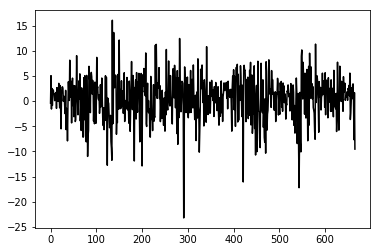

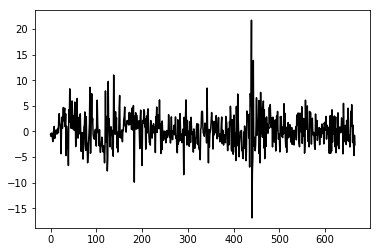

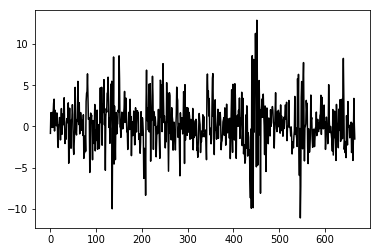

In [10]:
factors1= factorsA.values
factors1=factors1[:,1:5]
#print(factors1)
means_fac=np.zeros(3, dtype=float);
sd_fac=np.zeros(3, dtype=float);
sk_fac=np.zeros(3, dtype=float);
kurt_fac=np.zeros(3, dtype=float);
for i in range(0,3):
    means_fac[i] = np.mean(factors1[:,i])
    sd_fac[i] = np.sqrt(np.var(factors1[:,i]))
    sk_fac[i] = np.mean(np.power(factors1[:,i]-means_fac[i],3))/(np.power(sd_fac[i],3))
    kurt_fac[i] = np.mean(np.power(factors1[:,i]-means_fac[i],4))/(np.power(sd_fac[i],4))
    plt.plot(factors1[:,i],color='black')
    plt.show()

In [11]:
res_fac=np.vstack((means_fac, sd_fac,sk_fac,kurt_fac))
pd.DataFrame(res_fac, ["means", "sd", "skewness", "kurtosis excess"],
             [ "Mkt excess", "SMB", "HML"])



,Mkt excess,SMB,HML
means,0.512628,0.205916,0.324399
sd,4.386572,3.056775,2.797349
skewness,-0.544781,0.498842,0.089676
kurtosis excess,4.980212,8.401178,5.092188


In [12]:
y=Ri_Rf1[:,0]
X=pd.concat([factorsA['Mkt-RF'], factorsA['SMB'],factorsA['HML']], axis=1)
X = X.values
pd.DataFrame(OLS(y,X,"none"))

R2 0.9128694400138738
rho_1(u) 0.17202191316610255
DW 1.9343456246388757
z_DW -0.8471704380913505
pval z_DW 0.39690012836425925


,0,1,2,3
0,-0.495877,0.091842,-5.399235,6.692566e-08
1,1.094264,0.021995,49.750654,0.000000e+00
2,1.366044,0.031080,43.952185,0.000000e+00
3,-0.293710,0.033603,-8.740581,0.000000e+00


In [13]:
pd.DataFrame(OLS(y,X,"NW"))

R2 0.9128694400138738
rho_1(u) 0.17202191316610255
DW 1.9343456246388757
z_DW -0.8471704380913505
pval z_DW 0.39690012836425925


,0,1,2,3
0,-0.495877,0.103993,-4.768369,1.857234e-06
1,1.094264,0.029996,36.480914,0.000000e+00
2,1.366044,0.044682,30.572800,0.000000e+00
3,-0.293710,0.048596,-6.043932,1.504025e-09


In [14]:
coef_reg =np.zeros((4,4), dtype=float);
  
tabs_names = ["a", "b", "s", "h"]
  
Panel_B_a=np.zeros((5,5), dtype=float);
Panel_B_b=np.zeros((5,5), dtype=float);
Panel_B_s=np.zeros((5,5), dtype=float);
Panel_B_h=np.zeros((5,5), dtype=float);
  
Panel_B_a_t=np.zeros((5,5), dtype=float);
Panel_B_b_t=np.zeros((5,5), dtype=float);
Panel_B_s_t=np.zeros((5,5), dtype=float);
Panel_B_h_t=np.zeros((5,5), dtype=float);
n=0-1
Exogen=pd.concat([factorsA['Mkt-RF'], factorsA['SMB'],factorsA['HML']], axis=1)
Exogen=sm.add_constant(Exogen)
for i in range(0,5):
    for j in range(0,5):
        n=n+1
        lmodel1=sm.OLS(Ri_Rf1[:,n], Exogen)
        results= lmodel1.fit()
        Panel_B_a[i,j]=results.params[0]
        Panel_B_b[i,j]=results.params[1]
        Panel_B_s[i,j]=results.params[2]
        Panel_B_h[i,j]=results.params[3]
      
        Panel_B_a_t[i,j]=results.tvalues[0]
        Panel_B_b_t[i,j]=results.tvalues[1]
        Panel_B_s_t[i,j]=results.tvalues[2]
        Panel_B_h_t[i,j]=results.tvalues[3]

colnames=["Low", "2", "3", "4", "High"]
rowsnames=["Small", "2", "3", "4", "Big"]

pd.DataFrame(Panel_B_a, colnames,rowsnames)

,Small,2,3,4,Big
Low,-0.495877,-0.020604,-0.035660,0.162868,0.130081
2,-0.173797,0.008535,0.076915,0.063682,-0.031091
3,-0.088974,0.076478,-0.002308,0.073482,0.058562
4,0.109224,-0.050107,-0.030322,0.086050,-0.099553
High,0.169185,0.031599,0.003079,-0.213792,-0.178670


In [15]:
pd.DataFrame(Panel_B_b, colnames,rowsnames)

,Small,2,3,4,Big
Low,1.094264,0.975446,0.936687,0.878111,0.957030
2,1.131494,1.017700,0.966681,0.964033,1.072835
3,1.103888,1.036719,0.990462,0.976916,1.078379
4,1.079200,1.066951,1.046226,1.005403,1.164817
High,0.966998,0.991846,0.951881,1.030823,1.119709


In [16]:
pd.DataFrame(Panel_B_s, colnames,rowsnames)

,Small,2,3,4,Big
Low,1.366044,1.315385,1.078513,1.062835,1.077199
2,0.993197,0.883319,0.765496,0.709787,0.875457
3,0.735557,0.542619,0.430551,0.414921,0.555062
4,0.391564,0.198155,0.175966,0.201060,0.263022
High,-0.236769,-0.210803,-0.258291,-0.216322,-0.108364


In [17]:
pd.DataFrame(Panel_B_h, colnames,rowsnames)

,Small,2,3,4,Big
Low,-0.293710,0.040370,0.296748,0.443698,0.677107
2,-0.384099,0.116103,0.383449,0.567175,0.783692
3,-0.433558,0.167865,0.421828,0.595599,0.789917
4,-0.407764,0.188370,0.423893,0.552327,0.788525
High,-0.377092,0.086013,0.302078,0.644177,0.810314


In [18]:
pd.DataFrame(Panel_B_a_t, colnames,rowsnames)

,Small,2,3,4,Big
Low,-5.399235,-0.298010,-0.680279,3.122071,2.387538
2,-2.651736,0.152967,1.372192,1.295032,-0.591903
3,-1.505261,1.219242,-0.037034,1.213728,0.801528
4,1.835695,-0.737855,-0.436556,1.326490,-1.216452
High,3.864557,0.585899,0.046996,-3.506777,-1.924503


In [19]:
pd.DataFrame(Panel_B_b_t, colnames,rowsnames)

,Small,2,3,4,Big
Low,49.750654,58.911318,74.614399,70.286852,73.346495
2,72.087486,76.164931,72.012142,81.860734,85.285234
3,77.981529,69.013465,66.376128,67.378084,61.629569
4,75.736047,65.604390,62.895927,64.715709,59.431386
High,92.232184,76.792201,60.670206,70.602352,50.360650


In [20]:
pd.DataFrame(Panel_B_s_t, colnames,rowsnames)

,Small,2,3,4,Big
Low,43.952185,56.219565,60.798420,60.204587,58.423656
2,44.779793,46.783404,40.355640,42.653112,49.250948
3,36.772398,25.562700,20.419137,20.251898,22.449056
4,19.446514,8.622492,7.486237,9.158706,9.497060
High,-15.981592,-11.550193,-11.650405,-10.485158,-3.449145


In [21]:
pd.DataFrame(Panel_B_h_t, colnames,rowsnames)

,Small,2,3,4,Big
Low,-8.740581,1.595863,15.472514,23.246451,33.966832
2,-16.017536,5.687538,18.697115,31.524275,40.778416
3,-20.047422,7.314390,18.503512,26.888091,29.549052
4,-18.730682,7.581316,16.680073,23.270724,26.334085
High,-23.542259,4.358946,12.602500,28.879168,23.855250
